# Reaction Classifier v3: Chemistry + Transformation Features

**Train:** 3 Suzuki datasets + 2 C-N coupling datasets

**Test:** Chan-Lam (has boron like Suzuki but forms C-N bond)

**New features:** Uses Reaction SMILES to detect what changes (boron lost, halide lost)

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from ord_schema import message_helpers
from ord_schema.proto import dataset_pb2, reaction_pb2

from rdkit import Chem
from rdkit.Chem import Descriptors

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
import joblib

sns.set_style("whitegrid")
np.random.seed(42)

## 1. Load Datasets

In [2]:
DATASETS = {
    "suzuki": [
        "ord-data/data/68/ord_dataset-68cb8b4b2b384e3d85b5b1efae58b203.pb.gz",  # Perera 5760
        "ord-data/data/3b/ord_dataset-3b5db90e337942ea886b8f5bc5e3aa72.pb.gz",  # Ni-catalyzed 450
        "ord-data/data/3b/ord_dataset-3b8a2ef300e145468579027f206a3ac8.pb.gz",  # Cernak 1440
    ],
    "cn_coupling": [
        "ord-data/data/00/ord_dataset-00005539a1e04c809a9a78647bea649c.pb.gz",  # AstraZeneca 750
        "ord-data/data/cb/ord_dataset-cbcc4048add7468e850b6ec42549c70d.pb.gz",  # Pd-catalyzed 288
    ],
    "chan_lam": [
        "ord-data/data/5c/ord_dataset-5c9a10329a8a48968d18879a48bb8ab2.pb.gz",  # Chan-Lam 9632
    ],
}

CLASS_LABELS = {"suzuki": 0, "cn_coupling": 1, "chan_lam": 2}
LABEL_NAMES = {0: "Suzuki", 1: "C-N Coupling", 2: "Chan-Lam"}

In [3]:
def load_datasets(dataset_paths):
    all_reactions = []
    for reaction_class, paths in dataset_paths.items():
        label = CLASS_LABELS[reaction_class]
        for path in paths:
            print(f"Loading {path.split('/')[-1][:40]}...")
            try:
                dataset = message_helpers.load_message(path, dataset_pb2.Dataset)
                print(f"  -> {len(dataset.reactions)} reactions ({reaction_class})")
                for rxn in dataset.reactions:
                    all_reactions.append({
                        "reaction": rxn,
                        "class": reaction_class,
                        "label": label,
                        "dataset": dataset.name
                    })
            except Exception as e:
                print(f"  -> ERROR: {e}")
    return all_reactions

all_reactions = load_datasets(DATASETS)
print(f"\nTotal: {len(all_reactions)} reactions")
print(f"Suzuki: {sum(1 for r in all_reactions if r['label']==0)}")
print(f"C-N: {sum(1 for r in all_reactions if r['label']==1)}")

Loading ord_dataset-68cb8b4b2b384e3d85b5b1efae58...
  -> 5760 reactions (suzuki)
Loading ord_dataset-3b5db90e337942ea886b8f5bc5e3...
  -> 450 reactions (suzuki)
Loading ord_dataset-3b8a2ef300e145468579027f206a...
  -> 1440 reactions (suzuki)
Loading ord_dataset-00005539a1e04c809a9a78647bea...
  -> 750 reactions (cn_coupling)
Loading ord_dataset-cbcc4048add7468e850b6ec42549...
  -> 288 reactions (cn_coupling)
Loading ord_dataset-5c9a10329a8a48968d18879a48bb...
  -> 9632 reactions (chan_lam)

Total: 18320 reactions
Suzuki: 7650
C-N: 1038


## 2. Feature Extraction Functions

In [4]:
def get_smiles_from_reaction(reaction, roles=None):
    """Extract SMILES strings from a reaction by role."""
    smiles_list = []
    for key, inp in reaction.inputs.items():
        for comp in inp.components:
            role = reaction_pb2.ReactionRole.ReactionRoleType.Name(comp.reaction_role)
            if roles is not None and role not in roles:
                continue
            for ident in comp.identifiers:
                if reaction_pb2.CompoundIdentifier.CompoundIdentifierType.Name(ident.type) == "SMILES":
                    smiles_list.append({'smiles': ident.value, 'role': role})
                    break
    return smiles_list


def build_reaction_smiles(reaction):
    """Build Reaction SMILES: reactants>agents>products"""
    reactants = []
    agents = []
    products = []
    
    for key, inp in reaction.inputs.items():
        for comp in inp.components:
            role = reaction_pb2.ReactionRole.ReactionRoleType.Name(comp.reaction_role)
            for ident in comp.identifiers:
                if reaction_pb2.CompoundIdentifier.CompoundIdentifierType.Name(ident.type) == "SMILES":
                    if role == "REACTANT":
                        reactants.append(ident.value)
                    else:
                        agents.append(ident.value)
                    break
    
    for outcome in reaction.outcomes:
        for product in outcome.products:
            for ident in product.identifiers:
                if reaction_pb2.CompoundIdentifier.CompoundIdentifierType.Name(ident.type) == "SMILES":
                    products.append(ident.value)
                    break
    
    rxn_smiles = f"{'.'.join(reactants)}>{'.'.join(agents)}>{'.'.join(products)}"
    return rxn_smiles, reactants, agents, products


def get_elements(smiles):
    """Get set of elements in a molecule."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return set()
    return set(a.GetSymbol() for a in mol.GetAtoms())

In [5]:
def extract_full_features(reaction):
    """
    Extract chemistry + transformation features.
    
    Chemistry features: what's present in inputs
    Transformation features: what changes from reactants to products
    """
    features = {
        # --- Chemistry features (from inputs) ---
        'has_boron': 0,
        'has_boronic_acid': 0,
        'has_amine_nh': 0,
        'has_primary_amine': 0,
        'has_secondary_amine': 0,
        'has_aryl_chloride': 0,
        'has_aryl_bromide': 0,
        'has_aryl_iodide': 0,
        'has_triflate': 0,
        'has_palladium': 0,
        'has_nickel': 0,
        'has_copper': 0,
        'has_phosphine': 0,
        
        # --- Transformation features (from Reaction SMILES) ---
        'boron_lost': 0,
        'halide_lost': 0,
        
        # --- Signature features ---
        'suzuki_signature': 0,
        'cn_signature': 0,
    }
    
    # ============================
    # CHEMISTRY FEATURES
    # ============================
    
    # All molecules (for boron, metals, halogens)
    smiles_all = get_smiles_from_reaction(reaction, roles=None)
    if not smiles_all:
        return None
    
    # Only reactants (for amine detection)
    smiles_reactants = get_smiles_from_reaction(reaction, roles=['REACTANT'])
    
    # Process all molecules
    for item in smiles_all:
        mol = Chem.MolFromSmiles(item['smiles'])
        if mol is None:
            continue
        
        for atom in mol.GetAtoms():
            an = atom.GetAtomicNum()
            
            # Boron
            if an == 5:
                features['has_boron'] = 1
                o_neighbors = sum(1 for n in atom.GetNeighbors() if n.GetAtomicNum() == 8)
                if o_neighbors >= 2:
                    features['has_boronic_acid'] = 1
            
            # Halogens on aromatic carbon
            if an in [17, 35, 53]:  # Cl, Br, I
                for neighbor in atom.GetNeighbors():
                    if neighbor.GetIsAromatic() and neighbor.GetAtomicNum() == 6:
                        if an == 17: features['has_aryl_chloride'] = 1
                        elif an == 35: features['has_aryl_bromide'] = 1
                        elif an == 53: features['has_aryl_iodide'] = 1
                        break
            
            # Metals
            if an == 46: features['has_palladium'] = 1
            elif an == 28: features['has_nickel'] = 1
            elif an == 29: features['has_copper'] = 1
            
            # Phosphine
            if an == 15: features['has_phosphine'] = 1
        
        # Triflate
        triflate = Chem.MolFromSmarts('[OX2][SX4](=[OX1])(=[OX1])[CX4](F)(F)F')
        if triflate and mol.HasSubstructMatch(triflate):
            features['has_triflate'] = 1
    
    # Process only reactants for amine N-H
    for item in smiles_reactants:
        mol = Chem.MolFromSmiles(item['smiles'])
        if mol is None:
            continue
        for atom in mol.GetAtoms():
            if atom.GetAtomicNum() == 7 and atom.GetTotalNumHs() > 0 and not atom.GetIsAromatic():
                features['has_amine_nh'] = 1
                if atom.GetTotalNumHs() >= 2:
                    features['has_primary_amine'] = 1
                else:
                    features['has_secondary_amine'] = 1
    
    # ============================
    # TRANSFORMATION FEATURES
    # ============================
    
    rxn_smiles, reactants, agents, products = build_reaction_smiles(reaction)
    
    if products:
        reactant_elements = set()
        for r in reactants:
            reactant_elements |= get_elements(r)
        
        product_elements = set()
        for p in products:
            product_elements |= get_elements(p)
        
        lost = reactant_elements - product_elements
        
        features['boron_lost'] = 1 if 'B' in lost else 0
        features['halide_lost'] = 1 if bool(lost & {'Br', 'Cl', 'I'}) else 0
    
    # ============================
    # SIGNATURE FEATURES
    # ============================
    
    if features['has_boron'] == 1:
        features['suzuki_signature'] = 1
        features['cn_signature'] = 0
    elif features['has_amine_nh'] == 1:
        features['suzuki_signature'] = 0
        features['cn_signature'] = 1
    
    return features

## 3. Extract Features & Inspect

In [6]:
# Test on one reaction from each class
print("=== Sample Suzuki ===")
f = extract_full_features(all_reactions[0]['reaction'])
for k, v in f.items():
    if v != 0:
        print(f"  {k}: {v}")

print("\n=== Sample C-N ===")
for r in all_reactions:
    if r['class'] == 'cn_coupling':
        f = extract_full_features(r['reaction'])
        for k, v in f.items():
            if v != 0:
                print(f"  {k}: {v}")
        break

=== Sample Suzuki ===
  has_boron: 1
  has_boronic_acid: 1
  has_aryl_chloride: 1
  has_palladium: 1
  has_phosphine: 1
  boron_lost: 1
  halide_lost: 1
  suzuki_signature: 1

=== Sample C-N ===
  has_amine_nh: 1
  has_secondary_amine: 1
  has_aryl_bromide: 1
  has_palladium: 1
  has_phosphine: 1
  halide_lost: 1
  cn_signature: 1


In [13]:
# Extract features for all reactions
print("Extracting features...")

feature_list = []
labels = []

for rxn_data in tqdm(all_reactions):
    features = extract_full_features(rxn_data['reaction'])
    if features is not None:
        feature_list.append(features)
        labels.append(rxn_data['label'])

df_features = pd.DataFrame(feature_list)
y = np.array(labels)

print(f"\nExtracted: {len(df_features)} reactions")
print(f"Suzuki: {sum(y==0)}, C-N: {sum(y==1)}, Chan-Lam: {sum(y==2)}")

Extracting features...


100%|██████████| 18320/18320 [00:42<00:00, 427.27it/s]



Extracted: 18320 reactions
Suzuki: 7650, C-N: 1038, Chan-Lam: 9632


In [8]:
# Feature comparison by class
df_features['label'] = y
df_features['class_name'] = df_features['label'].map(LABEL_NAMES)

feature_cols = [c for c in df_features.columns if c not in ['label', 'class_name']]

comparison = df_features.groupby('class_name')[feature_cols].mean().T

print("Feature means by class:")
print("=" * 60)
print(comparison.round(3))

Feature means by class:
class_name           C-N Coupling  Chan-Lam  Suzuki
has_boron                   0.002     1.000   1.000
has_boronic_acid            0.002     1.000   0.749
has_amine_nh                0.995     1.000   0.138
has_primary_amine           0.460     1.000   0.000
has_secondary_amine         0.698     0.000   0.138
has_aryl_chloride           0.381     0.032   0.256
has_aryl_bromide            0.613     0.063   0.427
has_aryl_iodide             0.086     0.063   0.182
has_triflate                0.009     0.000   0.151
has_palladium               0.998     0.000   0.941
has_nickel                  0.000     0.000   0.059
has_copper                  0.000     1.000   0.000
has_phosphine               1.000     0.355   0.945
boron_lost                  0.000     1.000   1.000
halide_lost                 0.884     0.000   0.661
suzuki_signature            0.002     1.000   1.000
cn_signature                0.993     0.000   0.000


## 4. Train Classifier

In [9]:
# Prepare data
X = df_features[feature_cols].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

# Train models
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = {'model': model, 'accuracy': acc, 'f1': f1}
    print(f"\n{name}: Accuracy={acc:.4f}, F1={f1:.4f}")
    print(classification_report(y_test, y_pred, target_names=list(LABEL_NAMES.values())))

Train: 14656, Test: 3664

Decision Tree: Accuracy=1.0000, F1=1.0000
              precision    recall  f1-score   support

      Suzuki       1.00      1.00      1.00      1530
C-N Coupling       1.00      1.00      1.00       208
    Chan-Lam       1.00      1.00      1.00      1926

    accuracy                           1.00      3664
   macro avg       1.00      1.00      1.00      3664
weighted avg       1.00      1.00      1.00      3664


Random Forest: Accuracy=1.0000, F1=1.0000
              precision    recall  f1-score   support

      Suzuki       1.00      1.00      1.00      1530
C-N Coupling       1.00      1.00      1.00       208
    Chan-Lam       1.00      1.00      1.00      1926

    accuracy                           1.00      3664
   macro avg       1.00      1.00      1.00      3664
weighted avg       1.00      1.00      1.00      3664


Logistic Regression: Accuracy=1.0000, F1=1.0000
              precision    recall  f1-score   support

      Suzuki       1.00

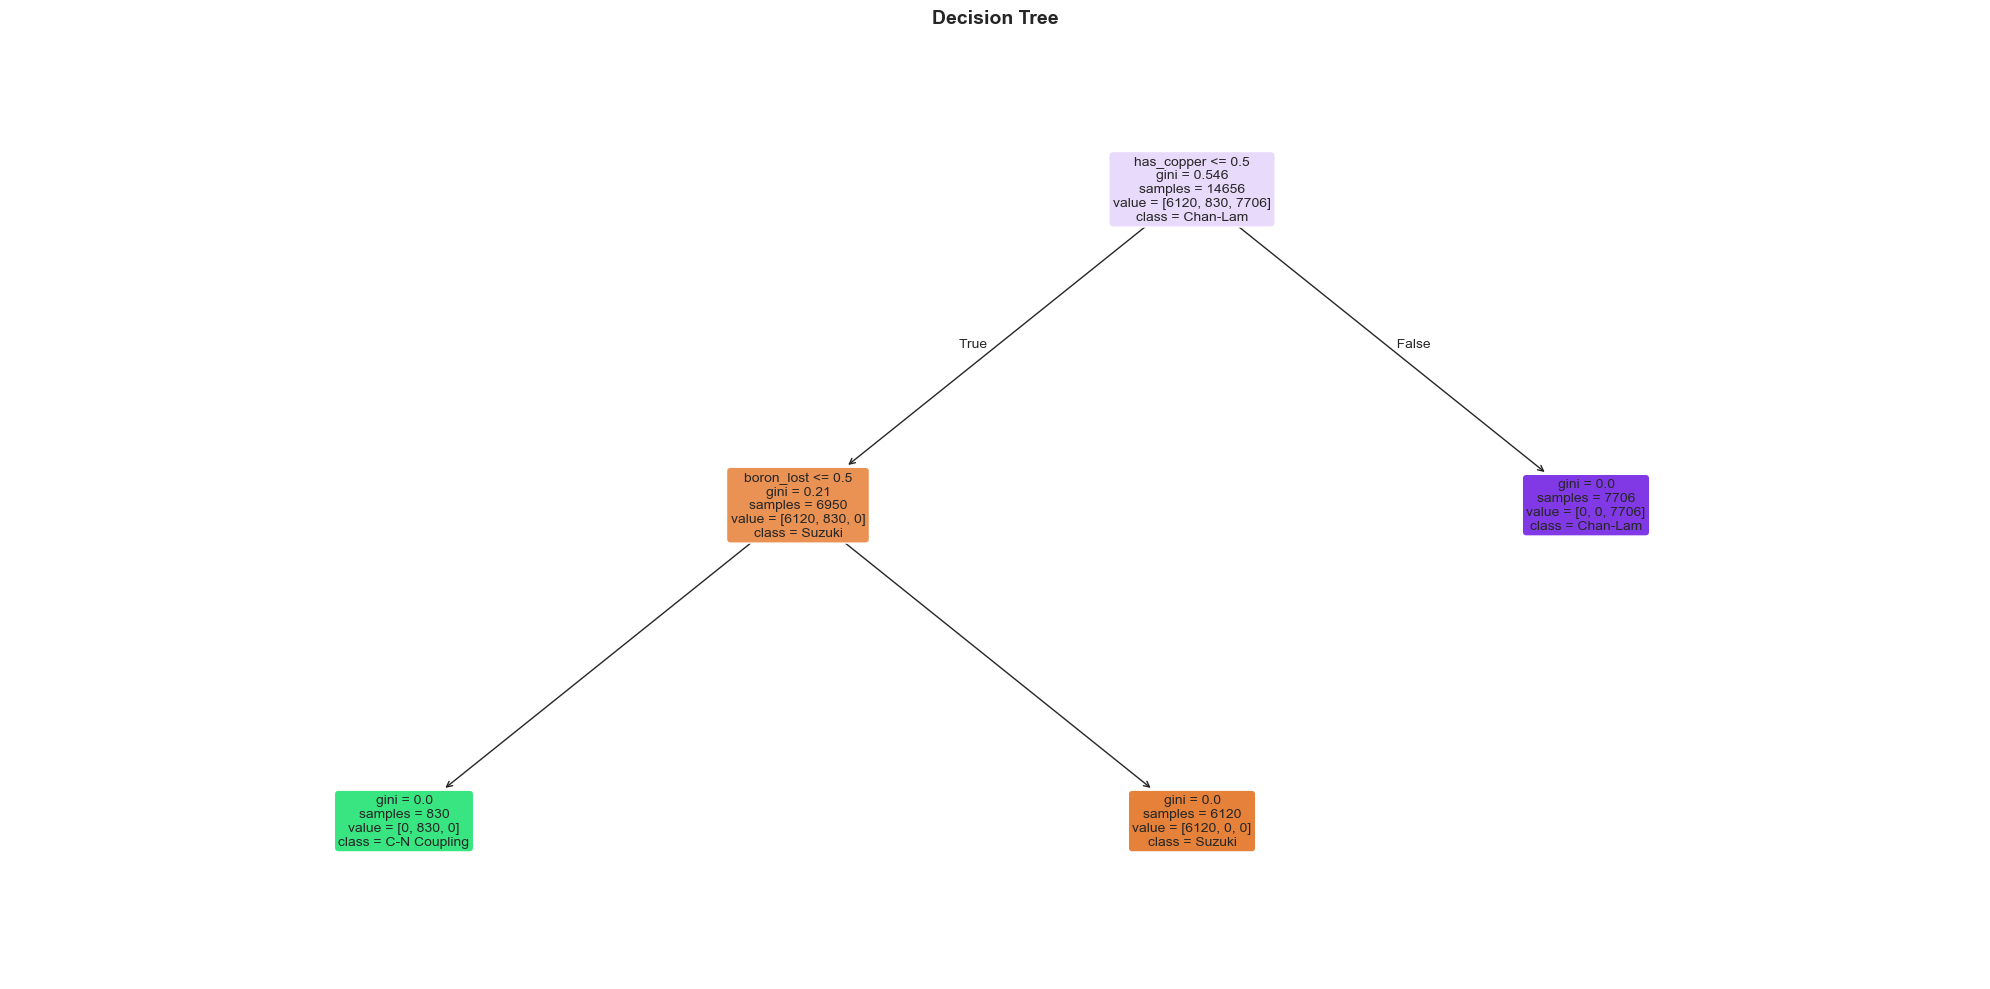

In [10]:
# Visualize Decision Tree
dt = results['Decision Tree']['model']
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(dt, feature_names=feature_cols, 
          class_names=list(LABEL_NAMES.values()),
          filled=True, rounded=True, ax=ax, fontsize=10)
plt.title('Decision Tree', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

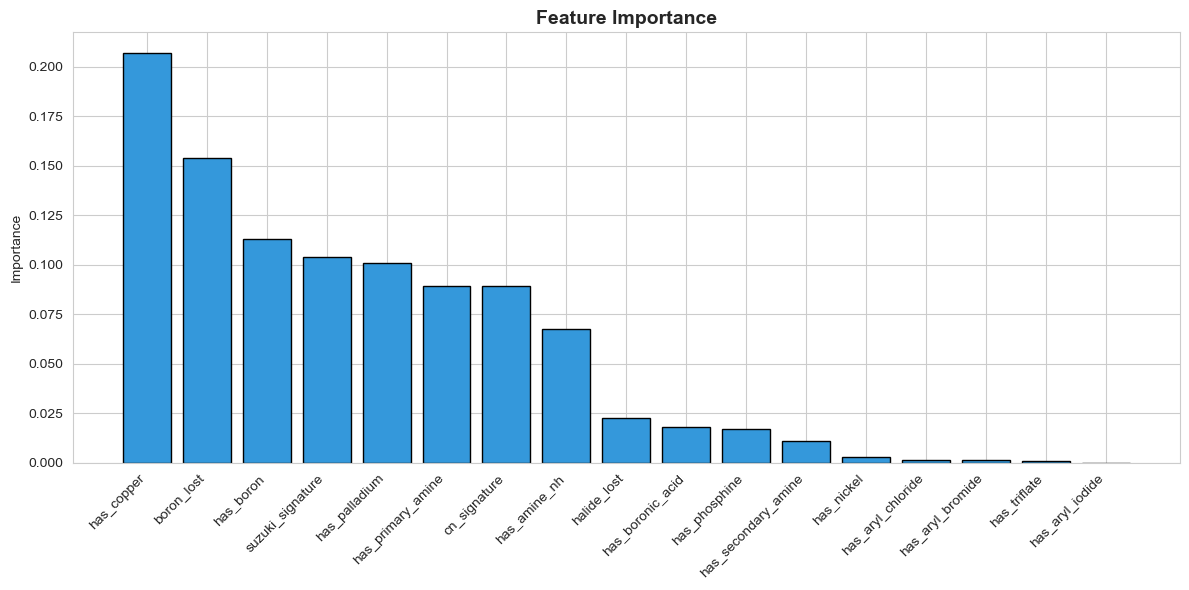

In [11]:
# Feature importance
rf = results['Random Forest']['model']
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(range(len(importances)), importances[indices], color='#3498db', edgecolor='black')
ax.set_xticks(range(len(importances)))
ax.set_xticklabels([feature_cols[i] for i in indices], rotation=45, ha='right')
ax.set_ylabel('Importance')
ax.set_title('Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [15]:
# External test on Reizman Suzuki
reizman_path = "ord-data/data/bc/ord_dataset-bc349c19b4384756a2aee8aa525b6c2a.pb.gz"
reizman = message_helpers.load_message(reizman_path, dataset_pb2.Dataset)

print(f"Testing on: {reizman.name}")
print(f"Reactions: {len(reizman.reactions)}")
print(f"Expected: Suzuki (label 0)\n")

best_model = results['Random Forest']['model']

predictions = {0: 0, 1: 0, 2: 0}
probabilities = []

for rxn in reizman.reactions:
    features = extract_full_features(rxn)
    if features is None:
        continue
    
    X_new = np.array([[features[col] for col in feature_cols]])
    pred = best_model.predict(X_new)[0]
    proba = best_model.predict_proba(X_new)[0]
    
    predictions[pred] += 1
    probabilities.append(proba)

total = sum(predictions.values())

print(f"{'='*50}")
print(f"PREDICTIONS ({total} reactions)")
print(f"{'='*50}")
print(f"  Suzuki:    {predictions[0]} ({100*predictions[0]/total:.1f}%)")
print(f"  C-N:       {predictions[1]} ({100*predictions[1]/total:.1f}%)")
print(f"  Chan-Lam:  {predictions[2]} ({100*predictions[2]/total:.1f}%)")

avg_proba = np.mean(probabilities, axis=0)
print(f"\nAverage confidence:")
print(f"  Suzuki:   {avg_proba[0]:.3f}")
print(f"  C-N:      {avg_proba[1]:.3f}")
print(f"  Chan-Lam: {avg_proba[2]:.3f}")

Testing on: Reizman Suzuki Cross-Coupling
Reactions: 96
Expected: Suzuki (label 0)

PREDICTIONS (96 reactions)
  Suzuki:    96 (100.0%)
  C-N:       0 (0.0%)
  Chan-Lam:  0 (0.0%)

Average confidence:
  Suzuki:   1.000
  C-N:      0.000
  Chan-Lam: 0.000
